<a href="https://colab.research.google.com/github/ScaratP/2025-Machine-Learning-HW/blob/main/11111124%E7%8E%8B%E6%9B%B8%E5%A7%B52025ML%E4%BD%9C%E6%A5%AD%E4%B8%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import modules....
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
from einops import rearrange
import warnings
warnings.filterwarnings('ignore')

# 設置隨機種子以確保結果可重現
np.random.seed(42)
torch.manual_seed(42)

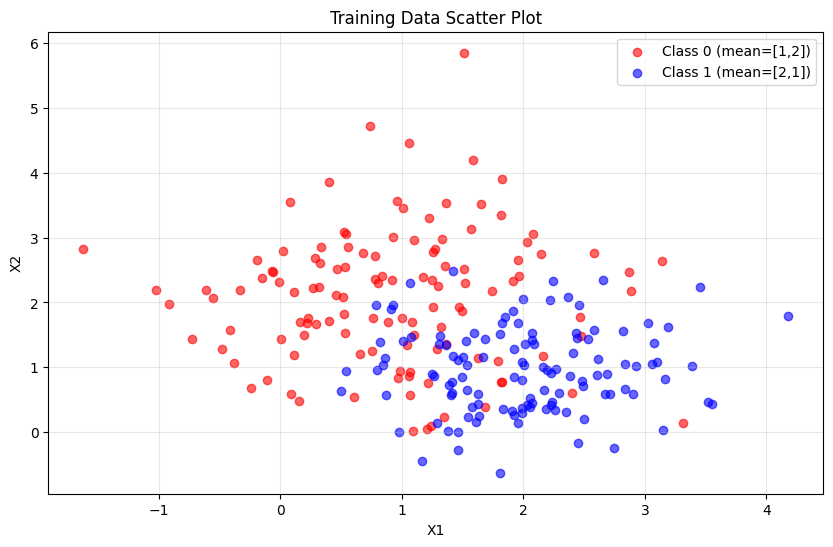

Training set size: 240
Test set size: 60


In [2]:
# draw the scatter plot of the training data set
# 生成高斯分布數據
# 類別0: mean=(1,2), variance=1
class0_data = np.random.multivariate_normal([1, 2], [[1, 0], [0, 1]], 150)
class0_labels = np.zeros(150)

# 類別1: mean=(2,1), variance=0.5
class1_data = np.random.multivariate_normal([2, 1], [[0.5, 0], [0, 0.5]], 150)
class1_labels = np.ones(150)

# 合併數據
all_data = np.vstack([class0_data, class1_data])
all_labels = np.hstack([class0_labels, class1_labels])

# 分割訓練集和測試集 (每類120個訓練，30個測試)
X_train_0, X_test_0 = class0_data[:120], class0_data[120:150]
y_train_0, y_test_0 = class0_labels[:120], class0_labels[120:150]

X_train_1, X_test_1 = class1_data[:120], class1_data[120:150]
y_train_1, y_test_1 = class1_labels[:120], class1_labels[120:150]

X_train = np.vstack([X_train_0, X_train_1])
y_train = np.hstack([y_train_0, y_train_1])
X_test = np.vstack([X_test_0, X_test_1])
y_test = np.hstack([y_test_0, y_test_1])

# 繪製訓練數據散點圖
plt.figure(figsize=(10, 6))
plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], c='red', alpha=0.6, label='Class 0 (mean=[1,2])')
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], c='blue', alpha=0.6, label='Class 1 (mean=[2,1])')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Training Data Scatter Plot')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

In [3]:
# build your solution

# 將2D數據轉換為圖像格式的輔助函數
def data_to_image(data, img_size=16):
    """將2D數據點轉換為圖像"""
    images = []
    for point in data:
        # 創建一個空白圖像
        img = np.zeros((img_size, img_size))

        # 標準化座標到圖像範圍
        x_norm = int((point[0] + 2) * img_size / 6)  # 假設數據範圍在[-2, 4]
        y_norm = int((point[1] + 1) * img_size / 5)  # 假設數據範圍在[-1, 4]

        # 確保座標在有效範圍內
        x_norm = max(0, min(img_size-1, x_norm))
        y_norm = max(0, min(img_size-1, y_norm))

        # 在對應位置設置高亮點
        img[y_norm, x_norm] = 1.0

        # 添加一些鄰近點以增加特徵
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                nx, ny = x_norm + dx, y_norm + dy
                if 0 <= nx < img_size and 0 <= ny < img_size:
                    img[ny, nx] = max(img[ny, nx], 0.5)

        images.append(img)

    return np.array(images)

# 轉換數據為圖像格式
X_train_img = data_to_image(X_train)
X_test_img = data_to_image(X_test)

# 添加通道維度 (1通道灰度圖像)
X_train_img = X_train_img.reshape(-1, 1, 16, 16)
X_test_img = X_test_img.reshape(-1, 1, 16, 16)

# 轉換為PyTorch張量
X_train_tensor = torch.FloatTensor(X_train_img)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test_img)
y_test_tensor = torch.LongTensor(y_test)

# 創建數據集和數據加載器
class ImageDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

train_dataset = ImageDataset(X_train_tensor, y_train_tensor)
test_dataset = ImageDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 定義簡化的Vision Transformer
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=16, patch_size=4, in_channels=1, embed_dim=64):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2

        self.projection = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.projection(x)  # (B, embed_dim, n_patches**0.5, n_patches**0.5)
        x = x.flatten(2)  # (B, embed_dim, n_patches)
        x = x.transpose(1, 2)  # (B, n_patches, embed_dim)
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim=64, n_heads=4):
        super().__init__()
        self.embed_dim = embed_dim
        self.n_heads = n_heads
        self.head_dim = embed_dim // n_heads

        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.n_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * (self.head_dim ** -0.5)
        attn = attn.softmax(dim=-1)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim=64, n_heads=4, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, n_heads)
        self.norm2 = nn.LayerNorm(embed_dim)

        mlp_hidden_dim = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class VisionTransformer(nn.Module):
    def __init__(self, img_size=16, patch_size=4, in_channels=1, n_classes=2,
                 embed_dim=64, depth=3, n_heads=4, mlp_ratio=4.0, dropout=0.1):
        super().__init__()

        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        n_patches = self.patch_embed.n_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, n_patches + 1, embed_dim))
        self.dropout = nn.Dropout(dropout)

        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, n_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])

        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, n_classes)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        x = x + self.pos_embed
        x = self.dropout(x)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)
        cls_token_final = x[:, 0]
        x = self.head(cls_token_final)

        return x

# 創建模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VisionTransformer().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"Using device: {device}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# 訓練模型
model.train()
for epoch in range(100):
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        total += target.size(0)

    if (epoch + 1) % 20 == 0:
        print(f'Epoch {epoch+1}/100, Loss: {total_loss/len(train_loader):.4f}, Accuracy: {100.*correct/total:.2f}%')

print("Training completed!")

Using device: cpu
Model parameters: 152,450
Epoch 20/100, Loss: 0.3209, Accuracy: 86.25%
Epoch 40/100, Loss: 0.2160, Accuracy: 88.75%
Epoch 60/100, Loss: 0.2214, Accuracy: 88.75%
Epoch 80/100, Loss: 0.2046, Accuracy: 89.58%
Epoch 100/100, Loss: 0.2038, Accuracy: 90.00%
Training completed!


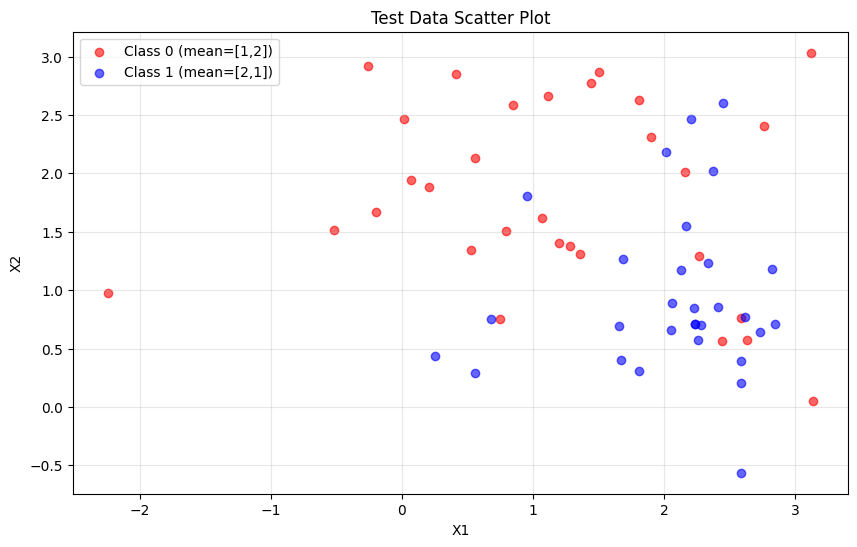

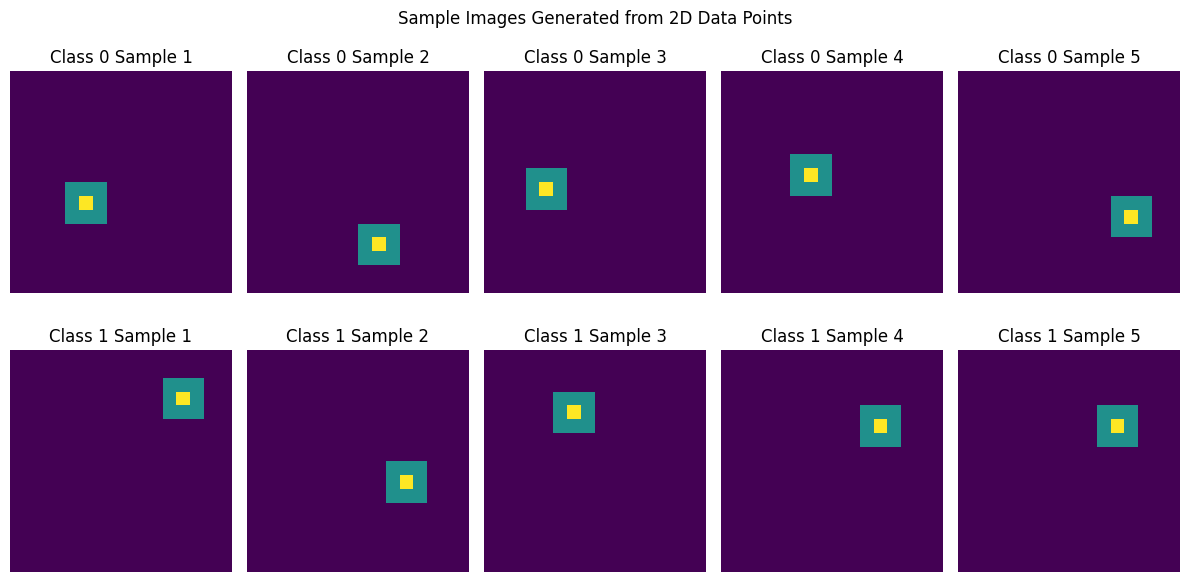

In [4]:
# the scatter plot of the test data
plt.figure(figsize=(10, 6))
plt.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], c='red', alpha=0.6, label='Class 0 (mean=[1,2])')
plt.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], c='blue', alpha=0.6, label='Class 1 (mean=[2,1])')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Test Data Scatter Plot')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 顯示一些轉換後的圖像樣本
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i in range(5):
    # 顯示類別0的圖像
    axes[0, i].imshow(X_test_img[i, 0], cmap='viridis')
    axes[0, i].set_title(f'Class 0 Sample {i+1}')
    axes[0, i].axis('off')

    # 顯示類別1的圖像
    axes[1, i].imshow(X_test_img[i+30, 0], cmap='viridis')
    axes[1, i].set_title(f'Class 1 Sample {i+1}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.suptitle('Sample Images Generated from 2D Data Points', y=1.02)
plt.show()

Vision Transformer (ViT) 分類結果
測試集大小: 60
正確預測數量: 42
測試集準確率: 70.00%

詳細分類報告:
                      precision    recall  f1-score   support

Class 0 (mean=[1,2])       0.75      0.60      0.67        30
Class 1 (mean=[2,1])       0.67      0.80      0.73        30

            accuracy                           0.70        60
           macro avg       0.71      0.70      0.70        60
        weighted avg       0.71      0.70      0.70        60


混淆矩陣:
[[18 12]
 [ 6 24]]


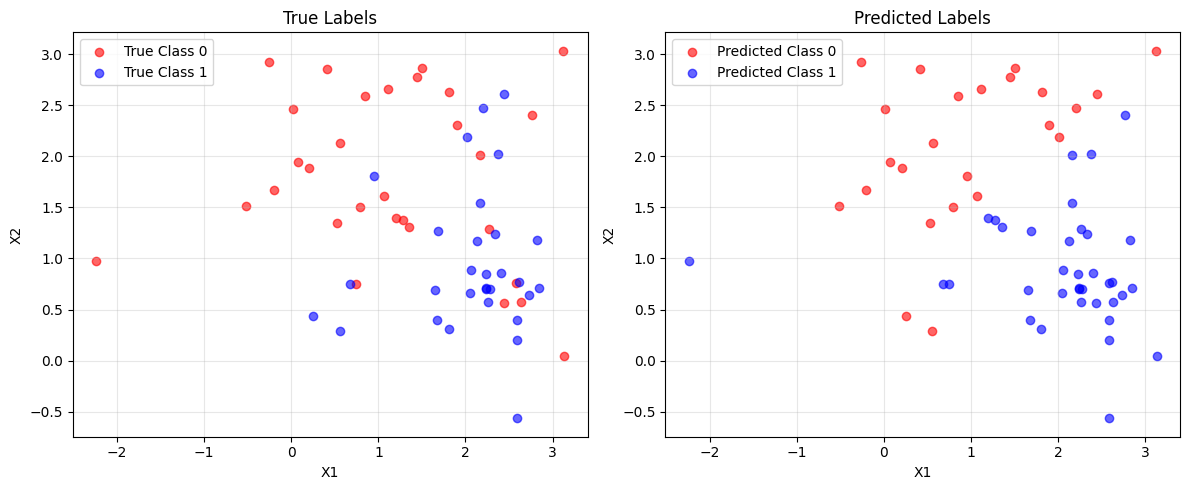


最終測試集準確率: 70.00%


In [5]:
# output the accuracy for the test data
model.eval()
correct = 0
total = 0
all_predictions = []
all_targets = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        total += target.size(0)

        all_predictions.extend(pred.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

test_accuracy = 100. * correct / total

print("="*50)
print("Vision Transformer (ViT) 分類結果")
print("="*50)
print(f"測試集大小: {total}")
print(f"正確預測數量: {correct}")
print(f"測試集準確率: {test_accuracy:.2f}%")
print("="*50)

# 詳細的分類報告
from sklearn.metrics import classification_report, confusion_matrix

print("\n詳細分類報告:")
print(classification_report(all_targets, all_predictions,
                          target_names=['Class 0 (mean=[1,2])', 'Class 1 (mean=[2,1])']))

print("\n混淆矩陣:")
cm = confusion_matrix(all_targets, all_predictions)
print(cm)

# 繪製預測結果
plt.figure(figsize=(12, 5))

# 原始測試數據
plt.subplot(1, 2, 1)
plt.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], c='red', alpha=0.6, label='True Class 0')
plt.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], c='blue', alpha=0.6, label='True Class 1')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('True Labels')
plt.legend()
plt.grid(True, alpha=0.3)

# 預測結果
plt.subplot(1, 2, 2)
pred_array = np.array(all_predictions)
plt.scatter(X_test[pred_array==0, 0], X_test[pred_array==0, 1], c='red', alpha=0.6, label='Predicted Class 0')
plt.scatter(X_test[pred_array==1, 0], X_test[pred_array==1, 1], c='blue', alpha=0.6, label='Predicted Class 1')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Predicted Labels')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n最終測試集準確率: {test_accuracy:.2f}%")